In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import *
from uta import Uta
from norm_layer import NormLayer

PATH = "uta.pt2"

# Data load

In [25]:
# Load data, split into train and test sets and create dataloaders
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
target = data[6]
print(sum(target==1))
print(sum(target==2))
print(sum(target==3))
print(sum(target==4))



target_map = {1: 0, 2: 0, 3: 1, 4: 1}
num_criteria = 6
data_input = data.iloc[:, :num_criteria]
data_target = data[num_criteria].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1, 1, num_criteria)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

1210
384
69
65


# Model creation and training

In [4]:
# Create model and train
uta = Uta(num_criteria, 30)
model = NormLayer(uta, num_criteria)
(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(model, train_dataloader, test_dataloader, PATH,epoch_nr=200,lr =0.0001,slope_decrease=True)

100%|██████████| 200/200 [00:03<00:00, 55.67it/s]


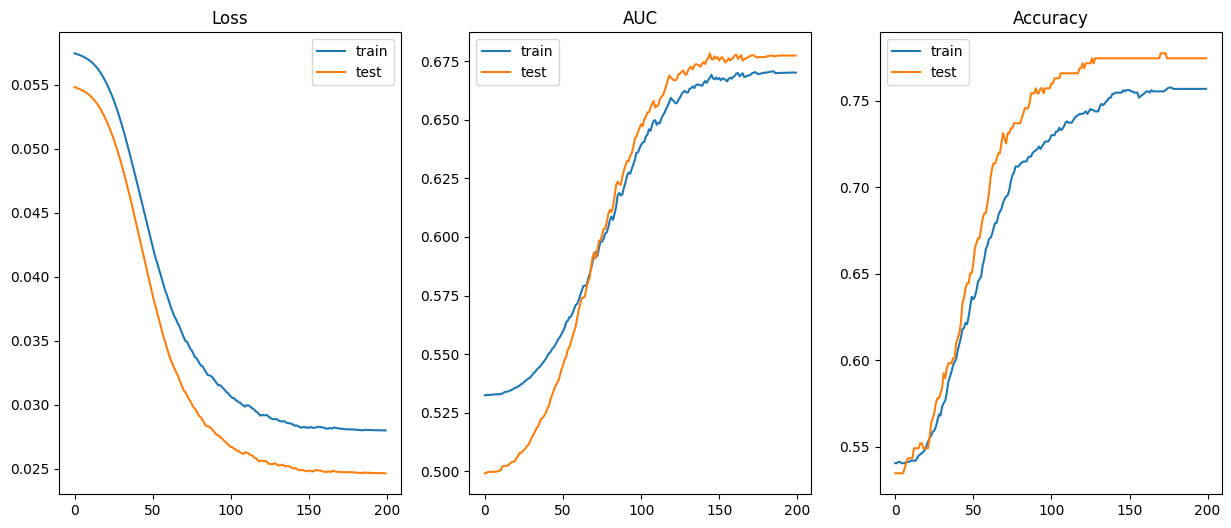

In [5]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

# Ploting marginal value functions of best model

In [6]:
# Load model from checkpoint
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [7]:


hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val,num_criteria)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
# We take every third value becouse the rest are from the normalization layer: velues for 0 and 1
outs = outs[::3] - outs[::3][0]
# Normalize the outputs to get proper weights of the criteria
outs = outs / outs[-1].sum()

/tmp/ipykernel_3059/4087062400.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())


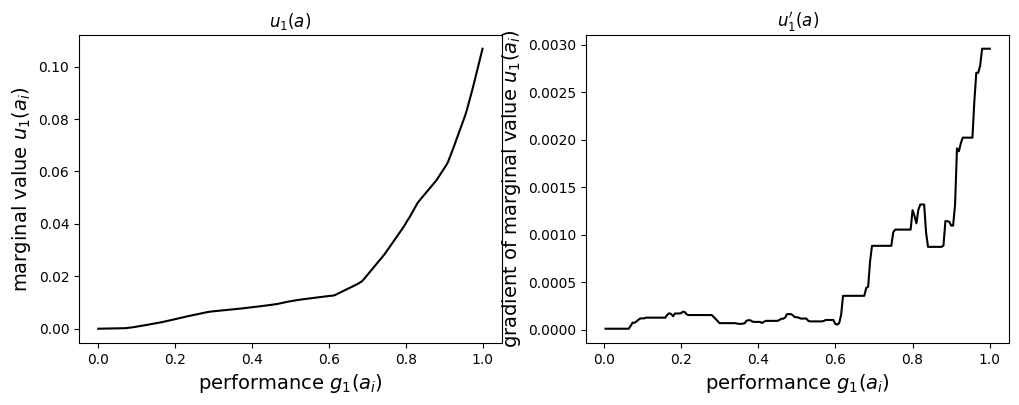

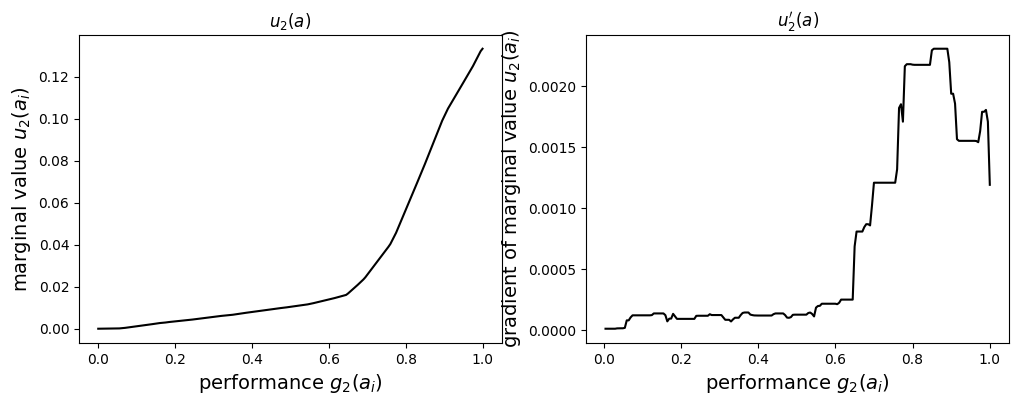

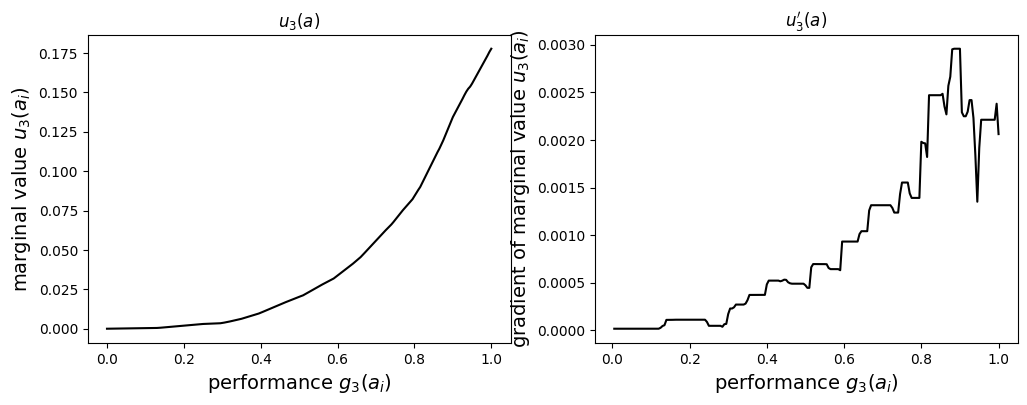

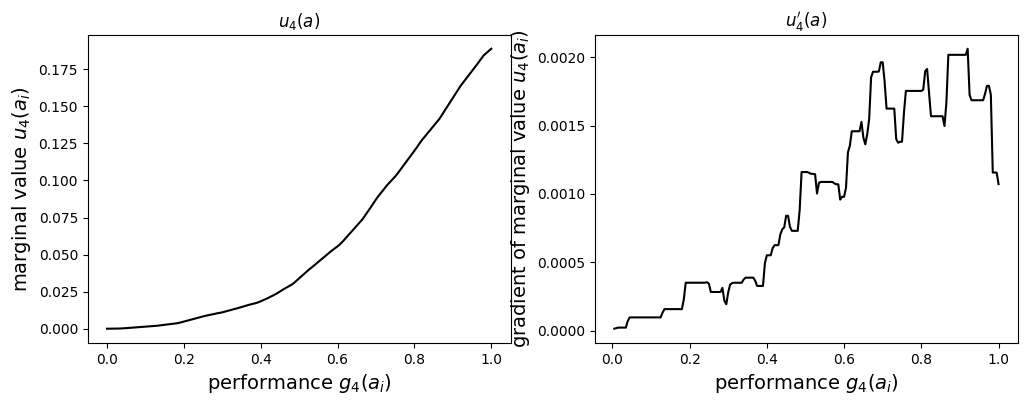

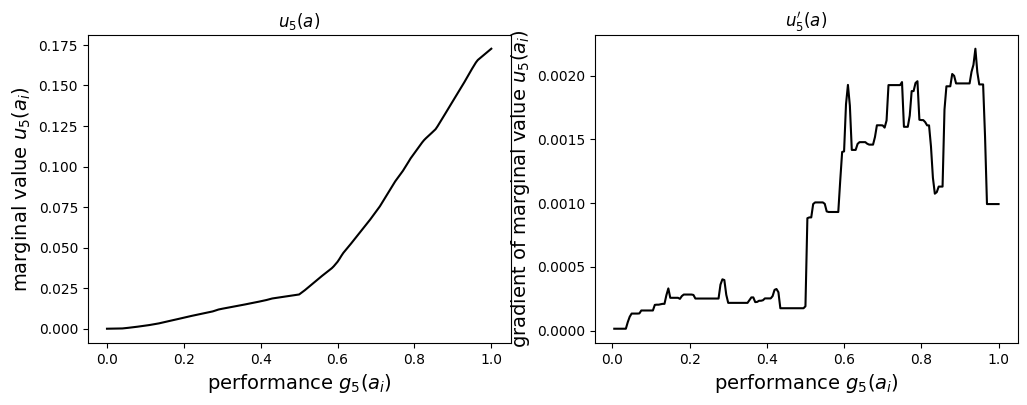

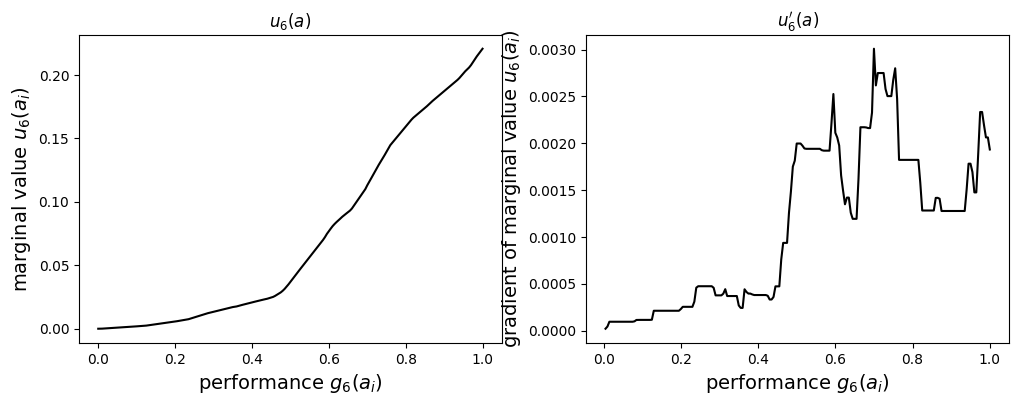

In [8]:
for i in range(num_criteria):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

In [28]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

def f1_score_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average="weighted")


model.eval()
with torch.no_grad():
    for x, y in train_dataloader:
        output = model(x)
        # reshape
        arr = output.numpy().reshape(-1, 1)
        scaler = StandardScaler()
        output = scaler.fit_transform(arr)
        y_pred = ((output > 0.5) * 1)
        y_true = y.numpy()
    
    
        print(f"F1 score: {f1_score_func(y_true, y_pred):.4f}")


F1 score: 0.7692


In [14]:
print(len(y_test))

346


In [18]:
print(sum(y_test == 1))
print(sum(y_test == 0))


26
320


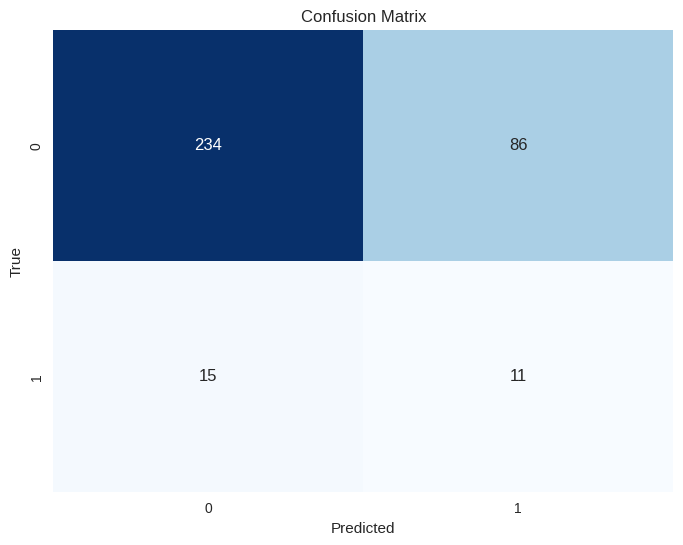

In [24]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
# plot confusion matrix
plot_confusion_matrix(y_true, y_pred)
